In [1]:
# importing libraries
import joblib
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from collections import defaultdict
import matplotlib.pyplot as plt

from models.logstic_regression import Logistic_Regression
from models.XGBoost import XGBoost
from models.naive_bayes import Naive_Bayes
from models.rnn import RNN
from models.cnn import CNN
# from models.bert import BERT
from models.bilstm import BiLSTM

# Load the TextPreprocessor class (assumed to be defined already)
from textpreprocessor import TextPreprocessor

import warnings
warnings.filterwarnings("ignore")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-10-19 17:59:38.949658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 17:59:38.993826: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 17:59:39.006414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 17:59:39.093541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-19 17:59:39.833677: W tensorflow/compiler/tf2

Num GPUs Available:  1


I0000 00:00:1729353581.778121  211851 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729353581.814339  211851 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729353581.814376  211851 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
NUM_SAMPLE = 10000
TEST_RATIO=0.2
BATCH_SIZE=32
EPOCHS = 5
MAX_WORD_COUNT = 5000
MAX_LENGTH = 100
OUTPUT_RESULT_DIR = "Output/result"
OUTPUT_MODELS_DIR = "Output/models"
USE_TEST_DATA = True


os.makedirs(OUTPUT_RESULT_DIR, exist_ok=True)
os.makedirs(OUTPUT_MODELS_DIR, exist_ok=True)

In [3]:
# Define a function to plot training history
def plot_training_history(history, title="Model Training History"):
    # Extract values from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot training history from defaultdict data
def plot_training_history_from_dict(history, title="Model Training History"):
    # Extract values from the dictionary
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    # Set up epoch range
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Dictionary to store the results
results = {
    'Model': [],
    'Training-Time':[],
    'Accuracy': [],
    'Precision (Class 0)': [],
    'Precision (Class 1)': [],
    'Recall (Class 0)': [],
    'Recall (Class 1)': [],
    'F1-Score (Class 0)': [],
    'F1-Score (Class 1)': []
}

# Function to calculate accuracy and classification report
def _evaluate_model(training_time, model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred) * 100
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store the results
    results['Model'].append(model_name)
    results['Training-Time'].append(training_time)
    results['Accuracy'].append(accuracy)
    results['Precision (Class 0)'].append(report['0']['precision'])
    results['Precision (Class 1)'].append(report['1']['precision'])
    results['Recall (Class 0)'].append(report['0']['recall'])
    results['Recall (Class 1)'].append(report['1']['recall'])
    results['F1-Score (Class 0)'].append(report['0']['f1-score'])
    results['F1-Score (Class 1)'].append(report['1']['f1-score'])

def _predict_model(model,X):
    y_pred_prob = model.predict(X)
    return [1 if prob > 0.5 else 0 for prob in y_pred_prob]

def evaluate_model_class(model_class, X_test, y_test):
    y_pred = _predict_model(model_class.model, X_test)
    y_pred_random = _predict_model(model_class.random_search_cv.best_estimator_, X_test)
    y_pred_grid = _predict_model(model_class.grid_search_cv.best_estimator_, X_test)
    y_pred_best = _predict_model(model_class.best_model, X_test)

    _evaluate_model(model_class.training_time, model_class.model_name, y_test, y_pred)
    _evaluate_model(model_class.random_search_time,  model_class.model_name + '_random_search', y_test, y_pred_random)
    _evaluate_model(model_class.grid_search_time,  model_class.model_name + '_grid_search', y_test, y_pred_grid)
    _evaluate_model(model_class.best_training_time,  model_class.model_name + '_best', y_test, y_pred_best)

    df_results = pd.DataFrame(results)
    df_results.to_excel(os.path.join(OUTPUT_RESULT_DIR,'Model_Compare.xlsx'))

def evaluate_xgboost_model_class(model_class, X_test, y_test):
    y_pred_xgb = _predict_model(model_class.model, model_class.convert_to_dmatrix(X_test, y_test))
    y_pred_xgb_random = _predict_model(model_class.random_search_cv.best_estimator_, X_test.toarray())
    y_pred_xgb_grid = _predict_model(model_class.grid_search_cv.best_estimator_, X_test.toarray())
    y_pred_xgb_best = _predict_model(model_class.best_model, model_class.convert_to_dmatrix(X_test, y_test))

    # Call the function with your actual predictions (replace placeholders with your data)
    _evaluate_model(model_class.training_time, model_class.model_name, y_test, y_pred_xgb)
    _evaluate_model(model_class.random_search_time,  model_class.model_name + '_random_search', y_test, y_pred_xgb_random)
    _evaluate_model(model_class.grid_search_time,  model_class.model_name + '_grid_search', y_test, y_pred_xgb_grid)
    _evaluate_model(model_class.best_training_time,  model_class.model_name + '_best', y_test, y_pred_xgb_best)

    df_results = pd.DataFrame(results)
    df_results.to_excel(os.path.join(OUTPUT_RESULT_DIR,'Model_Compare.xlsx'), index=False)


00. Text Pre-Processing

In [4]:
# Initialize the Text Preprocessor
processor = TextPreprocessor(MAX_WORD_COUNT, MAX_LENGTH)

if USE_TEST_DATA:
    INPUT_DIR = f"Output/proto_models_rev2_{NUM_SAMPLE}"
    # Load data
    df_train = pd.read_csv(os.path.join(INPUT_DIR, 'train_cleaned.csv'))
    df_test = pd.read_csv(os.path.join(INPUT_DIR, 'test_cleaned.csv'))
    # df_test = processor.load_data()
    X_train = df_train['review']
    X_test = df_test['review']
    y_train = df_train['polarity']
    y_test = df_test['polarity']
    # X_train_seq_padded = pickle.load(os.path.join(INPUT_DIR, 'X_train_pad.pkl'))
    # X_test_seq_padded = pickle.load(os.path.join(INPUT_DIR, 'X_test_pad.pkl'))
else:
    # Load data
    df_train, df_test = processor.parallel_load_data()

    df_train_step1 = processor.remove_stopwords(df_train.copy())
    df_test_step1 = processor.remove_stopwords(df_test.copy())

    print('----------TRAIN DATA----------')
    df_train_step2 = processor.filter_by_length_of_sentence(df_train_step1.copy(),50)
    print('----------TEST DATA----------')
    df_test_step2 = processor.filter_by_length_of_sentence(df_test_step1.copy(),50)

    df_train_step3 = processor.sampling_data(df_train_step2, NUM_SAMPLE)
    df_test_step3 = processor.sampling_data(df_test_step2, int(NUM_SAMPLE*TEST_RATIO))

    # Preprocess data
    df_train_step3 = processor.map_polarity(df_train_step3.copy())
    df_test_step3 = processor.map_polarity(df_test_step3.copy())

    # Split data
    X_train, y_train = processor.split_data(df_train_step3)
    X_test, y_test = processor.split_data(df_test_step3)

X_train_tfidf, X_test_tfidf = processor.vectorize_text(X_train, X_test)
X_train_pad, X_test_pad = processor.tokenization_and_padding(X_train, X_test)

MAX_LENGTH = processor.max_length

01. Logistic Regression

In [5]:
# 1. Train Model
logistic_regression = Logistic_Regression()
logistic_regression.train_model(X_train_tfidf, y_train)

# 2. Random SearchCV
logistic_regression.random_search(X_train_tfidf, y_train, n_iter=50, cv=3, verbos=0, random_state=42, n_jobs=-1)
# logistic_regression.random_search(X_tfidf=X_train_tfidf, y=y_train, n_iter=7200, cv=3, verbos=0, random_state=42, n_jobs=-1)

# 3. Grid SearchCV
logistic_regression.grid_search(X_train_tfidf, y_train, n_iter=50, cv=2, verbos=0, random_state=42, n_jobs=-1,best_params=logistic_regression.random_search_cv.best_params_)
# logistic_regression.grid_search(X_train_tfidf, y_train, n_iter=7200, cv=2, verbos=0, random_state=42, n_jobs=-1,best_params=logistic_regression.random_search_cv.best_params_)

# 4. Train Best Model
logistic_regression.train_best_model(X_train_tfidf, y_train, logistic_regression.grid_search_cv.best_params_)

# 5. Evaluate and Save Models
evaluate_model_class(logistic_regression,X_test_tfidf, y_test)

logistic_regression.save_model_and_params(
    os.path.join(OUTPUT_MODELS_DIR, 'logistic_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'logistic_best_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'logistic_best_params.pkl')
    )

/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/woong/AI/

Model saved to Output/models/logistic_model.pkl
Best model saved to Output/models/logistic_best_model.pkl
Best parameters saved to Output/models/logistic_best_params.pkl


02. XGBoost

In [6]:
# 1. Train Model
xgboost = XGBoost()
xgboost.train_model(X_train_tfidf, y_train)

# 2. Random SearchCV
xgboost.random_search(X_train_tfidf, y_train, n_iter=2, cv=2, verbos=0, random_state=42, n_jobs=-1)

# 3. Grid SearchCV
xgboost.grid_search(X_train_tfidf, y_train, cv=2, verbos=0, n_jobs=-1, best_params=xgboost.random_search_cv.best_params_)

# 4. Train Best Model
xgboost.train_best_model(X_train_tfidf, y_train, xgboost.grid_search_cv.best_params_)

# 5. Evaluate and Save Models
evaluate_xgboost_model_class(xgboost, X_test_tfidf, y_test)

xgboost.save_model_and_params(
    os.path.join(OUTPUT_MODELS_DIR, 'xgboost_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'xgboost_best_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'xgboost_best_params.pkl')
    )

Best parameters found: {'tree_method': 'hist', 'subsample': 0.75, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.125, 'gamma': 0.0, 'device': 'cuda', 'colsample_bytree': 0.9}
Best parameters found by GridSearchCV: {'colsample_bytree': 0.9500000000000001, 'device': 'cuda', 'gamma': 0.05, 'learning_rate': 0.135, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.775, 'tree_method': 'hist'}
Model saved to Output/models/xgboost_model.pkl
Best model saved to Output/models/xgboost_best_model.pkl
Best parameters saved to Output/models/xgboost_best_params.pkl


03. Naive Bayes

In [7]:
# 1. Train Model
naive_bayes = Naive_Bayes()
naive_bayes.train_model(X_train_tfidf, y_train)

# 2. Random SearchCV
# naive_bayes.random_search(X_train_tfidf, y_train, n_iter=30, cv=2, verbos=0, random_state=42, n_jobs=-1)
naive_bayes.random_search(X_train_tfidf, y_train, n_iter=3000, cv=3, verbos=1, random_state=42, n_jobs=-1)

# 3. Grid SearchCV
# naive_bayes.grid_search(X_train_tfidf, y_train, naive_bayes.random_search_cv.best_params_, cv=2, verbos=1, n_jobs=-1)
naive_bayes.grid_search(X_train_tfidf, y_train, naive_bayes.random_search_cv.best_params_, cv=5, verbos=1, n_jobs=-1)

# 4. Train Best Model
naive_bayes.train_best_model(X_train_tfidf, y_train, naive_bayes.grid_search_cv.best_params_)

# 5. Evaluate and Save Models
evaluate_model_class(naive_bayes,X_test_tfidf, y_test)

naive_bayes.save_model_and_params(
    os.path.join(OUTPUT_MODELS_DIR, 'naivebayes_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'naivebayes_best_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'naivebayes_best_params.pkl')
    )

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
Best parameters from RandomizedSearchCV: {'fit_prior': False, 'alpha': 0.959520260130065}
Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
Best parameters from GridSearchCV: {'alpha': 1.9302173298370358, 'fit_prior': False}
Model saved to Output/models/naivebayes_model.pkl
Best model saved to Output/models/naivebayes_best_model.pkl
Best parameters saved to Output/models/naivebayes_best_params.pkl


04. Recurrent Neural Network

In [8]:
# 1. Train Model
rnn = RNN(max_feature=5000, max_length=100, epochs=2, batch_size=64, output_dim=128, optimizer='adam', embedding_dim=32, rnn_unit=64, verbose=1)
rnn.train_model(X_train_pad, y_train, validation_data=(X_test_pad, y_test))

# 2. Random SearchCV
rnn.random_search(X_train_pad, y_train, (X_test_pad, y_test), n_iter=3, cv=2,  random_state=42, n_jobs=1)

# 3. Grid SearchCV
rnn.grid_search(X_train_pad, y_train, (X_test_pad, y_test), cv=2, n_jobs=1, best_params=rnn.random_search_cv.best_params_)

# 4. Train Best Model
rnn.train_best_model(X_train_pad,y_train, validation_data=(X_test_pad, y_test), best_params= rnn.grid_search_cv.best_params_)

# 5. Evaluate and Save Models
evaluate_model_class(rnn,X_test_pad, y_test)

rnn.save_model_and_params(
    os.path.join(OUTPUT_MODELS_DIR, 'rnn_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'rnn_best_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'rnn_best_params.pkl')
    )

I0000 00:00:1729353688.573037  211851 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729353688.573094  211851 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729353688.573110  211851 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729353688.581645  211851 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729353688.581686  211851 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-19

Epoch 1/2


I0000 00:00:1729353689.796324  213937 service.cc:146] XLA service 0x7fdf48003db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729353689.796533  213937 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-19 18:01:29.824167: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-19 18:01:29.933229: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


  3/157 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5312 - loss: 0.6955

I0000 00:00:1729353690.393685  213937 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5416 - loss: 0.6879 - val_accuracy: 0.5680 - val_loss: 0.6821
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8238 - loss: 0.4460 - val_accuracy: 0.7925 - val_loss: 0.4515
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5555 - loss: 0.6825 - val_accuracy: 0.7045 - val_loss: 0.5818
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8069 - loss: 0.4828 - val_accuracy: 0.7735 - val_loss: 0.4837
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9001 - loss: 0.3137 - val_accuracy: 0.8105 - val_loss: 0.4348
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9462 - loss: 0.1966 - val_accuracy: 0.7940 - val_loss: 0.4574
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9680 - loss: 0.1377 - val_accuracy: 0.7870 - val_loss: 0.4968
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accurac

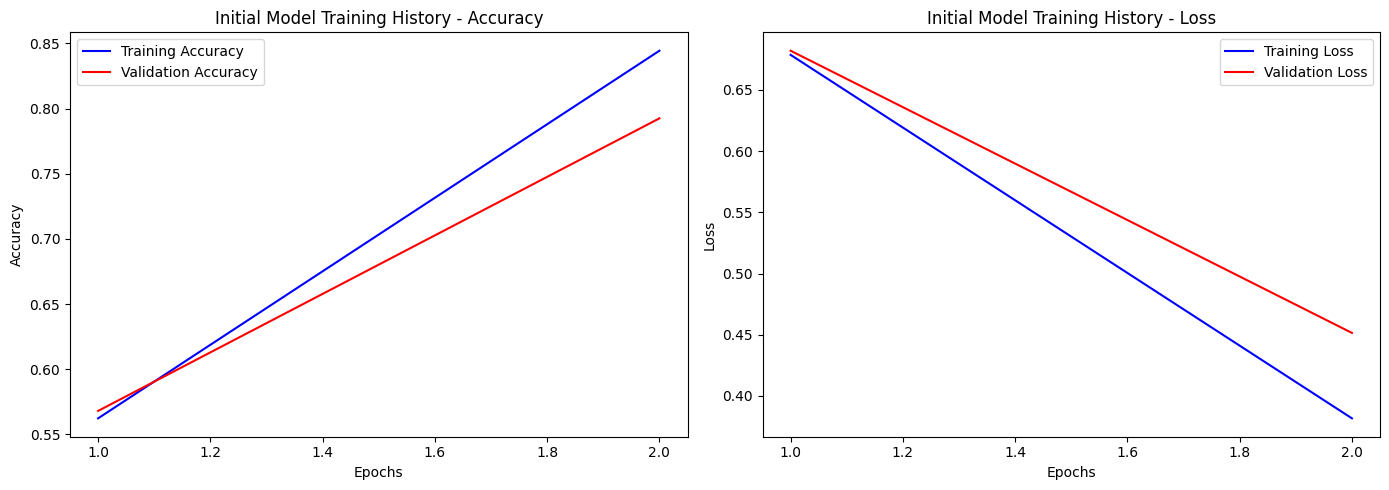

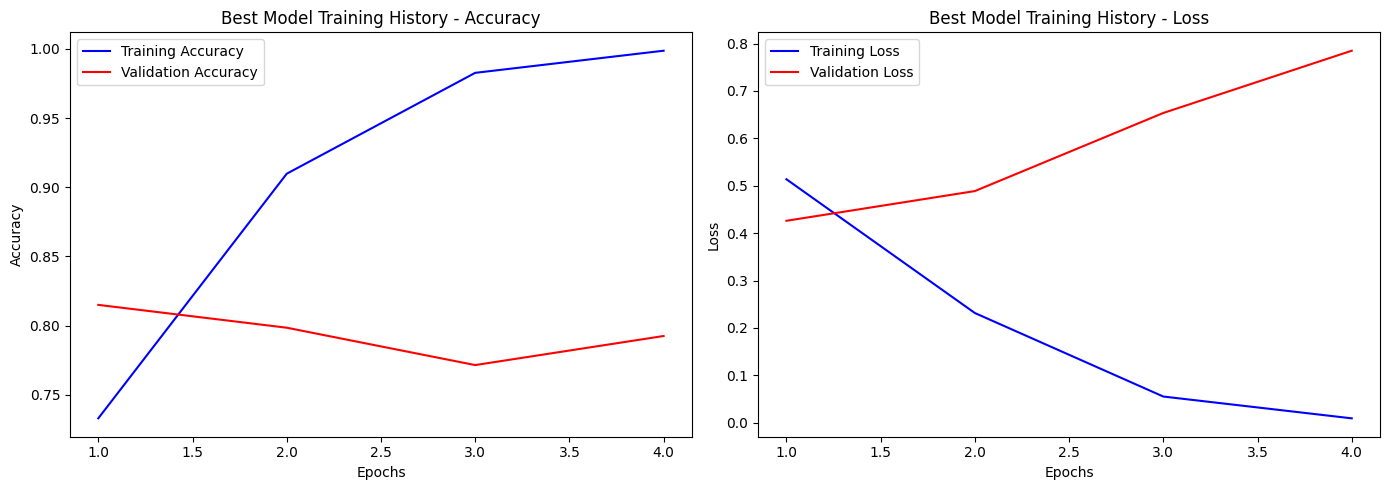

In [9]:
# Plot for hist
plot_training_history_from_dict(rnn.model.history_, title="Initial Model Training History")

# Plot the training history from defaultdict data
plot_training_history_from_dict(rnn.best_model.history_, title="Best Model Training History")

05. Convolutional Neural Network

In [10]:
# 1. Train Model
cnn = CNN(max_feature=processor.max_features, max_length=processor.max_length, epochs=EPOCHS, batch_size=BATCH_SIZE, output_dim=128, optimizer='adam', embedding_dim=32, verbose=1)
cnn.train_model(X_train_pad, y_train, (X_test_pad, y_test))

# 2. Random SearchCV
cnn.random_search(X_train_pad, y_train, (X_test_pad, y_test), n_iter=2, cv=2, random_state=42, n_jobs=1, patience=3)

# 3. Grid SearchCV
cnn.grid_search(X_train_pad, y_train, (X_test_pad, y_test), best_params=cnn.random_search_cv.best_params_, cv=2, n_jobs=1, patience=3)

# 4. Train Best Model
cnn.train_best_model(X_train_pad, y_train, (X_test_pad, y_test), best_params=cnn.grid_search_cv.best_params_)

# 5. Evaluate and Save Models
evaluate_model_class(cnn,X_test_pad, y_test)

cnn.save_model_and_params(
    os.path.join(OUTPUT_MODELS_DIR, 'cnn_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'cnn_best_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'cnn_best_params.pkl')
    )

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6127 - loss: 0.6150 - val_accuracy: 0.8200 - val_loss: 0.3870
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8918 - loss: 0.2729 - val_accuracy: 0.8320 - val_loss: 0.3843
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9396 - loss: 0.1667 - val_accuracy: 0.8225 - val_loss: 0.4372
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9736 - loss: 0.0847 - val_accuracy: 0.8175 - val_loss: 0.6557
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9920 - loss: 0.0283 - val_accuracy: 0.8075 - val_loss: 0.8178
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5141 - loss: 0.6947 - val_accuracy: 0.5530 - val_loss: 0.6890
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5435 - loss: 0.6890 - val_accuracy: 0.5910 - val_loss: 0.6813
Epoch 3/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

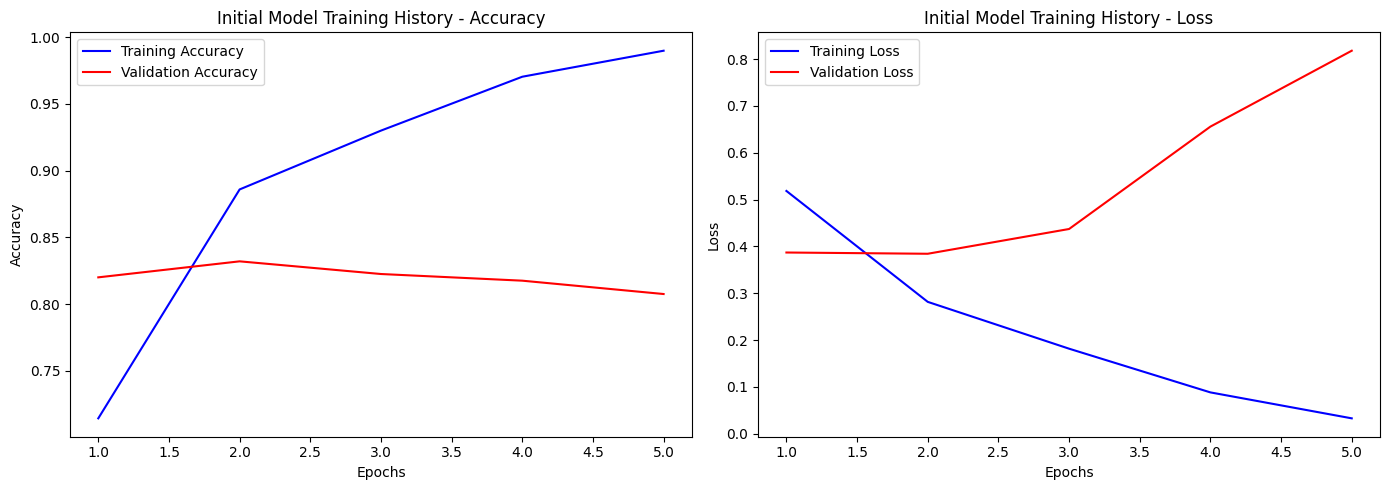

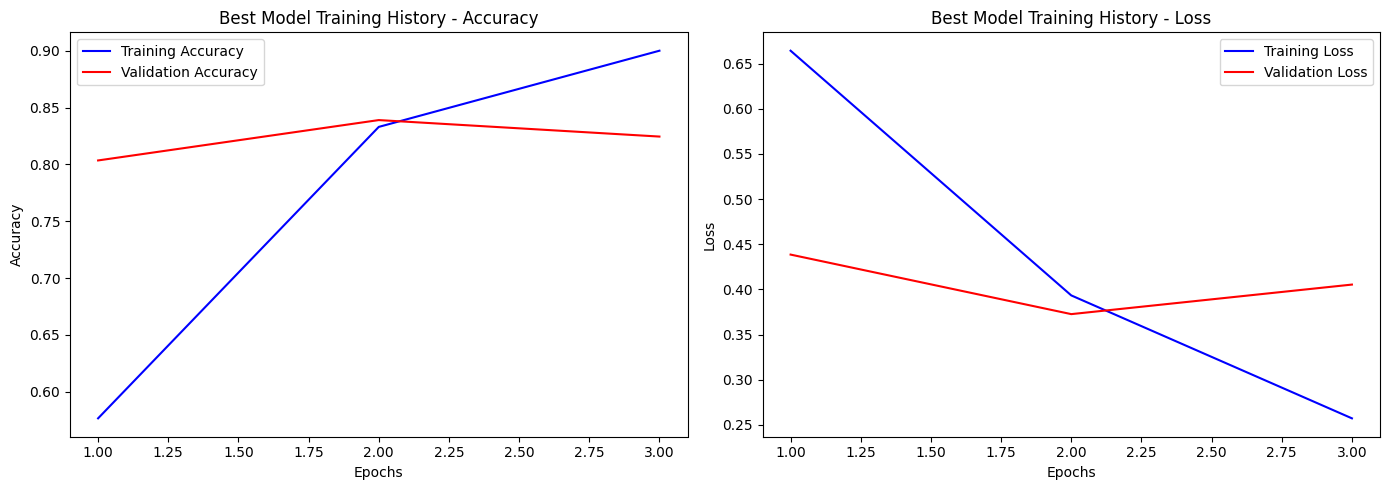

In [11]:
# Plot for hist
plot_training_history_from_dict(cnn.model.history_, title="Initial Model Training History")

# Plot the training history from defaultdict data
plot_training_history_from_dict(cnn.best_model.history_, title="Best Model Training History")

06. Bidirectional Encoder Representations from Transformers(BERT)

In [14]:
# bert = BERT(max_length=processor.max_features, epochs=1, batch_size=BATCH_SIZE, verbose=1)
# bert.train_model(X_train, y_train, X_test, y_test)

# bert.random_search(X_train, y_train, X_test, y_test, max_trials=2, executions_per_trial=1, n_jobs=1)

# # Predict on test data
# y_pred_prob = bert_model.predict({'input_ids': bert.X_test_tokens['input_ids'], 'attention_mask': bert.X_test_tokens['attention_mask']}).logits
# y_pred_bert = np.argmax(y_pred_prob, axis=-1)

07. Bidirectional Long Short-Term Memory (BiLSTM)

In [13]:
# 1. Train Model
bilstm = BiLSTM(processor.tokenizer, EPOCHS, BATCH_SIZE)
bilstm.train_model(X_train_pad, y_train, X_test_pad,y_test)

# 2. Random SearchCV
bilstm.random_search(X_train_pad, y_train, X_test_pad,y_test, n_iter=2, cv=2, random_state=42, n_jobs=1)

# 3. Grid SearchCV
bilstm.grid_search(X_train_pad, y_train, X_test_pad, y_test, best_params= bilstm.random_search_cv.best_params_, cv=3, n_jobs=1, patience=3)

# 4. Train Best Model
bilstm.train_best_model(X_train_pad, y_train, X_test_pad, y_test, best_params=bilstm.grid_search_cv.best_params_, patience=3)

# 5. Evaluate and Save Models
evaluate_model_class(bilstm,X_test_pad, y_test)

bilstm.save_model_and_params(
    os.path.join(OUTPUT_MODELS_DIR, 'bilstm_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'bilstm_best_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'bilstm_best_params.pkl')
    )

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6644 - loss: 0.5859 - val_accuracy: 0.8270 - val_loss: 0.3825
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8977 - loss: 0.2567 - val_accuracy: 0.8105 - val_loss: 0.4527
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9441 - loss: 0.1552 - val_accuracy: 0.8155 - val_loss: 0.5040
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9716 - loss: 0.0907 - val_accuracy: 0.8085 - val_loss: 0.7070
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6447 - loss: 0.6141 - val_accuracy: 0.7950 - val_loss: 0.4284
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9161 - loss: 0.2303 - val_accuracy: 0.8100 - val_loss: 0.4506
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9568 - loss: 0.1203 - val_accuracy: 0.8050 - val_loss: 0.5510
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9805 - loss: 0.0659 - val_accuracy: 0.

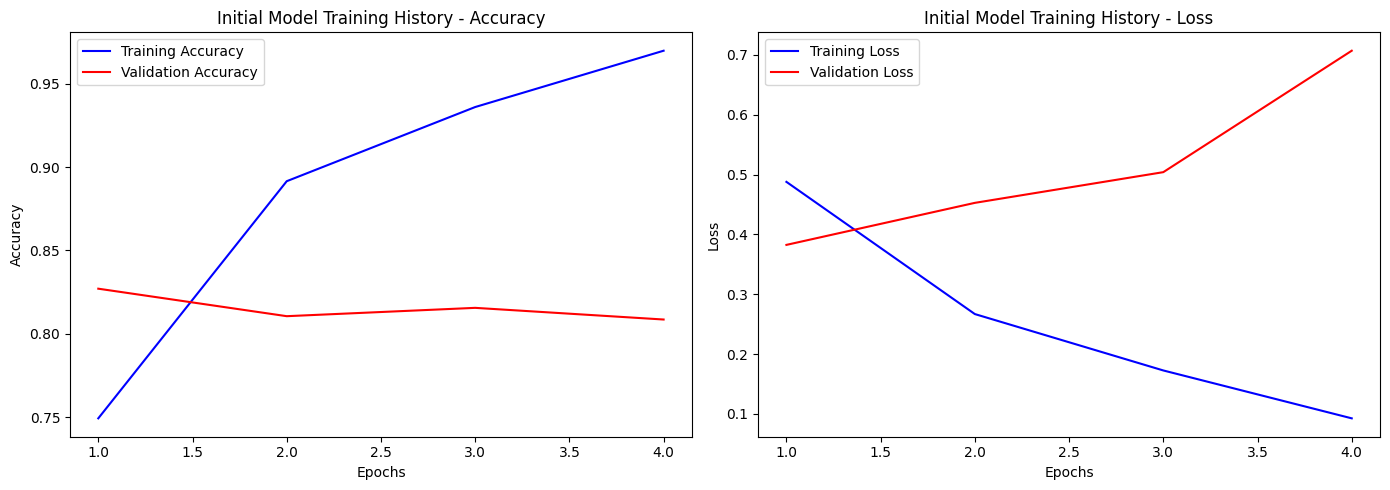

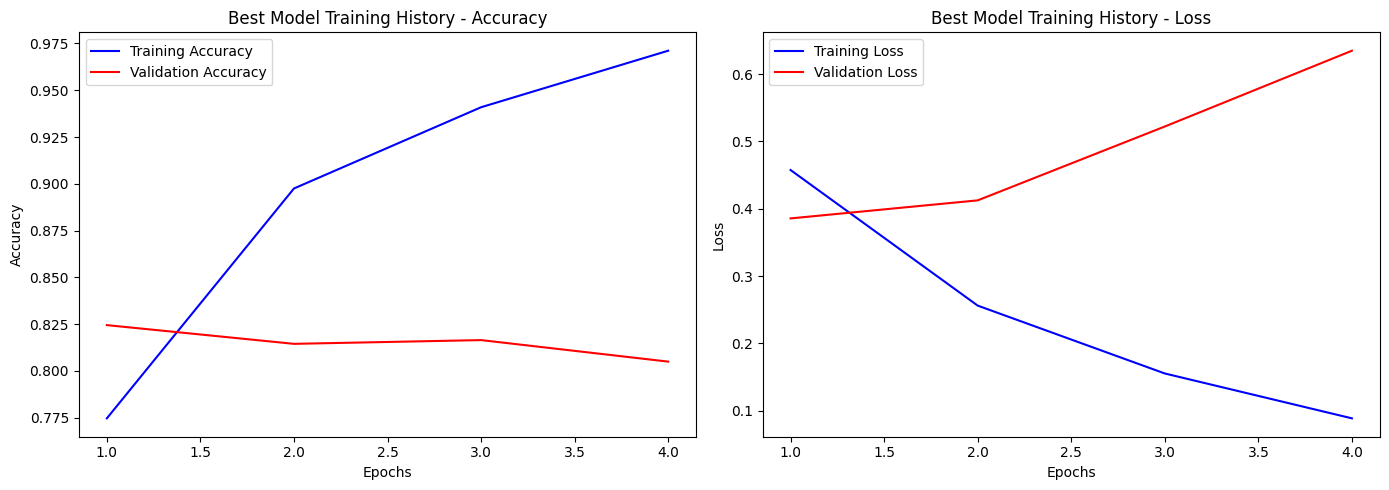

In [14]:
# Plot for hist
plot_training_history_from_dict(bilstm.model.history_, title="Initial Model Training History")

# Plot the training history from defaultdict data
plot_training_history_from_dict(bilstm.best_model.history_, title="Best Model Training History")

In [22]:
df_results = pd.DataFrame(results)